# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [501]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
%matplotlib inline
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from urllib.error import HTTPError

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

634

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
# OpenWeatherMap API Key
api_key = "19f617e49bc08fb97137c4f01a36e91d"

# Starting URL for Weather Map API Call
url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=" + api_key

city_name = []
cloudiness = []
country = []
date = []
humidity = []
lat = []
lng = []
max_temp = []
wind_speed = []

# Start the call counter 
record = 1

# Log file print statement
print(f"Beginning Data Retrieval")
print(f"-------------------------------")

#Loop through the cities in the city list 
for city in cities:  
    
    # Try statement to append calls where value is found 
    # Not all calls return data as OpenWeatherMap will not have have records in all the cities generated by CityPy module
    try: 
        response = requests.get(f"{url}&q={city}").json() 
        city_name.append(response["name"])
        cloudiness.append(response["clouds"]["all"])
        country.append(response["sys"]["country"])
        date.append(response["dt"])
        humidity.append(response["main"]["humidity"])
        max_temp.append(response["main"]["temp_max"])
        lat.append(response["coord"]["lat"])
        lng.append(response["coord"]["lon"])
        wind_speed.append(response["wind"]["speed"])
        city_record = response["name"]
        print(f"Processing Record {record} | {city_record}")
        print(f"{url}&q={city}")
        
        # Increase counter by one 
        record= record + 1
        
        # Wait a second in loop to not over exceed rate limit of API
        time.sleep(1.01)
        
    # If no record found "skip" to next call
    except:
        print("City not found. Skipping...")
    continue

Beginning Data Retrieval
-------------------------------
Processing Record 1 | Mataura
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=19f617e49bc08fb97137c4f01a36e91d&q=mataura
Processing Record 2 | Tiksi
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=19f617e49bc08fb97137c4f01a36e91d&q=tiksi
Processing Record 3 | Severo-Kuril'sk
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=19f617e49bc08fb97137c4f01a36e91d&q=severo-kurilsk
Processing Record 4 | Novyy Buh
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=19f617e49bc08fb97137c4f01a36e91d&q=novyy buh
Processing Record 5 | Smithers
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=19f617e49bc08fb97137c4f01a36e91d&q=smithers
Processing Record 6 | El Alto
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=19f617e49bc08fb97137c4f01a36e91d&q=el alto
Processing Record 7 | Lebu
http://api.openweathermap.org/data/2.5/weather?units=

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [422]:
# Creating a dictionary with my lists, containing the data returned from OpenWeather JSON.
city_weather_dict = pd.DataFrame({
     'City':city_name,
     'Cloudiness':cloudiness,
     'Country':country,
     'Date':date,
     'Humidity':humidity,
     'Lat':lat,
     'Lng':lng,
     'Max Temperature':max_temp,
     'Wind Speed':wind_speed,
    })

# Creating a dataframe, from my dictionary
city_data = pd.DataFrame(city_weather_dict)
city_data.to_csv("sanity/city_data.csv", index="True")
city_data.head()

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temperature,Wind Speed
0,Mataura,85,NZ,1589746747,91,-46.19,168.86,44.83,2.48
1,Tiksi,100,RU,1589746503,95,71.69,128.87,33.10,12.46
2,Severo-Kuril'sk,100,RU,1589746750,93,50.68,156.12,35.28,21.27
3,Novyy Buh,40,UA,1589746751,93,47.69,32.52,51.80,4.47
4,Smithers,90,CA,1589746752,82,54.78,-127.17,55.40,8.05


In [423]:
# Get the indices of cities that have humidity over 100%.
print(f'Current DataFrame shape: ', city_data.shape)
humidity_indicies = city_data[city_data['Humidity']>100].index.tolist()

# if else statement to determine whether to print values that break the >100 Humidity threshold, or
# print a message confirming their aren't any.
if not humidity_indicies:
    print("Warning: there are no 'Humidity' column values greater than 100")
else:
    print(humidity_indicies)

Current DataFrame shape:  (583, 9)


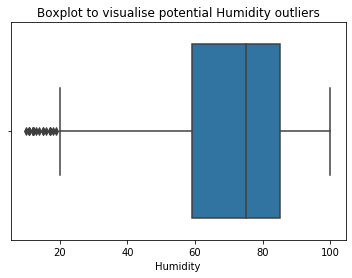

In [424]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.

# <DO SOMETHING>

# creating boxplot to visualise potential 'Humidity' outliers
fig1 = sns.boxplot(x=city_data['Humidity']).set_title("Boxplot to visualise potential Humidity outliers")

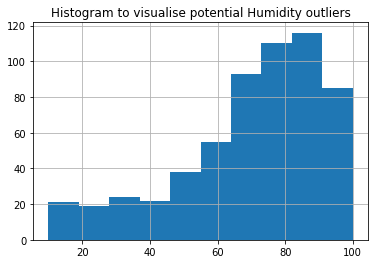

In [425]:
# histogram to
fig2 = city_data.Humidity.hist().set_title("Histogram to visualise potential Humidity outliers")

In [426]:
# Calculating the IQR for the Humidity column
Q1 = city_data['Humidity'].quantile(0.25)
print(f'Humidity Q1 is: {Q1}')
Q3 = city_data['Humidity'].quantile(0.75)
print(f'Humidity Q3 is: {Q3}')
IQR = Q3 - Q1
print(f'Humidity IQR: {IQR}')

# Having analysed the graphic representations of the city_data Dataframe, I removed outliers equal to or less than 45
# and equal to or greater than 100
index = city_data[(city_data['Humidity'] >= 100)|(city_data['Humidity'] <= 45)].index
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
city_data.drop(index, inplace=True)

# printing new dataframe shape, to demonstrate outliers for Humidity have removed entire rows impacted
print(f'New Dataframe shape: {city_data.shape}')

chart_df = pd.DataFrame(city_data)

Humidity Q1 is: 59.0
Humidity Q3 is: 85.0
Humidity IQR: 26.0
New Dataframe shape: (486, 9)


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

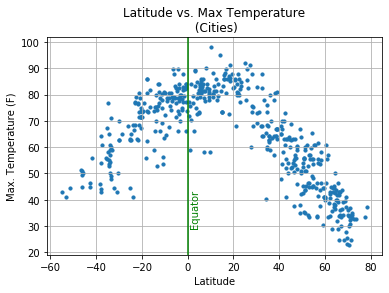

In [486]:
# Build a scatter plot or each data type
fig3 = plt.scatter(chart_df["Lat"], chart_df["Max Temperature"], marker="o", s=10)

plt.title("Latitude vs. Max Temperature\n (Cities)")
plt.xlabel("Latitude")
plt.ylabel("Max. Temperature (F)")
# Adding an equator line, as a reference point
plt.axvline(0, color = 'green', alpha = 1, label = 'Equator')
plt.text(1,30,'Equator',rotation=90, color = 'green', alpha = 1)
plt.grid(True)

# Saving out the figure
plt.savefig("output_plots/City_Lat_vs_Max Temp.png")
plt.show()

## Latitude vs. Humidity Plot

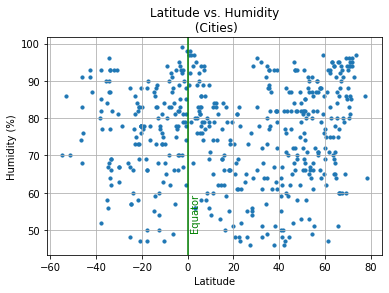

In [487]:
# Build a scatter plot for each data type
fig4 = plt.scatter(chart_df["Lat"], chart_df["Humidity"], marker="o", s=10)

plt.title("Latitude vs. Humidity\n (Cities)")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
# Adding an equator line, as a reference point
plt.axvline(0, color = 'green', alpha = 1, label = 'Equator')
plt.text(1,50,'Equator',rotation=90, color = 'green', alpha = 1)
plt.grid(True)

# Saving out the figure
plt.savefig("output_plots/City_Lat_vs_Humidity.png")

plt.show()

## Latitude vs. Cloudiness Plot

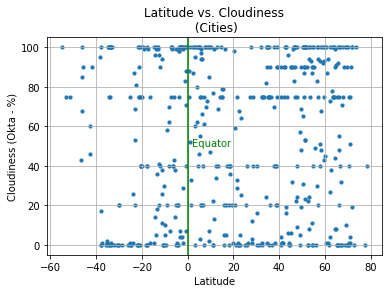

In [488]:
# Build a scatter plot for each data type
fig5 = plt.scatter(chart_df["Lat"], chart_df["Cloudiness"], marker="o", s=10)

# Adding Scatter 
plt.title("Latitude vs. Cloudiness\n (Cities)")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (Okta - %)")
# Adding an equator line, as a reference point
plt.axvline(0, color = 'green', alpha = 1, label = 'Equator')
plt.text(1.9,50,'Equator',rotation=0, color = 'green', alpha = 1)
plt.grid(True)

# Saving out the figure
plt.savefig("output_plots/City_Lat_vs_Cloudiness.png")

plt.show()

## Latitude vs. Wind Speed Plot

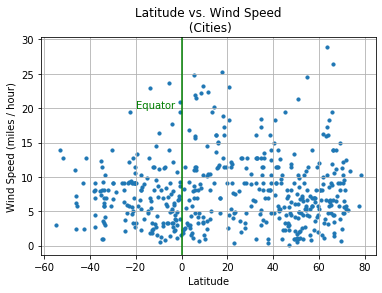

In [489]:
# Build a scatter plot for each data type
fig6 = plt.scatter(chart_df["Lat"], chart_df["Wind Speed"], marker="o", s=10)

# Adding Scatter 
plt.title("Latitude vs. Wind Speed\n (Cities)")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (miles / hour)")
# Adding an equator line, as a reference point
plt.axvline(0, color = 'green', alpha = 1, label = 'Equator')
plt.text(-20,20,'Equator',rotation=0, color = 'green', alpha = 1)
plt.grid(True)

# Saving out the figure
plt.savefig("output_plots/City_Lat_vs_Wind_Speed.png")

plt.show()

## Linear Regression

In [490]:
# OPTIONAL: Create a function to create Linear Regression plots



In [491]:
# Create Northern and Southern Hemisphere DataFrames

# Using groupby function to split chart_dt DataFrame, based on those Latitude values less than zero, hence those countries in the Northern & Southern Hemisphere.
Northern_Hemisphere, Southern_Hemisphere = [x for _, x in chart_df.groupby(chart_df['Lat'] < 0)]

# Sanity checking the output of the Northern Hemisphere DataFrame.
Northern_Hemisphere.to_csv("sanity/Northern_Hemisphere.csv", index="True")
Northern_Hemisphere.head()

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temperature,Wind Speed
1,Tiksi,100,RU,1589746503,95,71.69,128.87,33.10,12.46
2,Severo-Kuril'sk,100,RU,1589746750,93,50.68,156.12,35.28,21.27
3,Novyy Buh,40,UA,1589746751,93,47.69,32.52,51.80,4.47
4,Smithers,90,CA,1589746752,82,54.78,-127.17,55.40,8.05
9,Los Llanos de Aridane,40,ES,1589746759,64,28.66,-17.92,68.00,12.75


In [451]:
# Sanity checking the output of the Southern Hemisphere DataFrame.
Southern_Hemisphere.to_csv("sanity/Southern_Hemisphere.csv", index="True")
Southern_Hemisphere.head()

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temperature,Wind Speed
0,Mataura,85,NZ,1589746747,91,-46.19,168.86,44.83,2.48
5,El Alto,0,PE,1589746753,70,-4.27,-81.21,73.74,17.72
6,Lebu,1,CL,1589746527,77,-37.62,-73.65,60.73,4.50
7,Soyo,43,AO,1589746756,84,-6.13,12.37,78.94,7.11
8,Saint-Philippe,90,RE,1589746757,73,-21.36,55.77,71.60,9.17


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

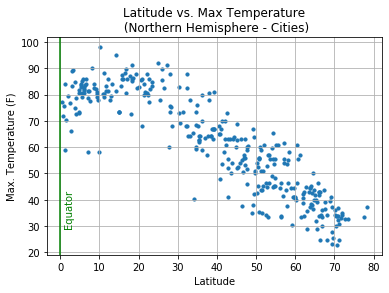

In [492]:
# Build a scatter plot or each data type
fig7 = plt.scatter(Northern_Hemisphere["Lat"], Northern_Hemisphere["Max Temperature"], marker="o", s=10)

plt.title("Latitude vs. Max Temperature\n (Northern Hemisphere - Cities)")
plt.xlabel("Latitude")
plt.ylabel("Max. Temperature (F)")
# Adding an equator line, as a reference point
plt.axvline(0, color = 'green', alpha = 1, label = 'Equator')
plt.text(1,30,'Equator',rotation=90, color = 'green', alpha = 1)
plt.grid(True)

# Saving out the figure
plt.savefig("output_plots/Northern_Lat_vs_Max Temp.png")
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

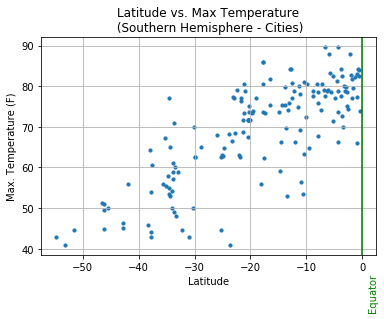

In [499]:
# Build a scatter plot or each data type
fig8 = plt.scatter(Southern_Hemisphere["Lat"], Southern_Hemisphere["Max Temperature"], marker="o", s=10)

plt.title("Latitude vs. Max Temperature\n (Southern Hemisphere - Cities)")
plt.xlabel("Latitude")
plt.ylabel("Max. Temperature (F)")
# Adding an equator line, as a reference point
plt.axvline(0, color = 'green', alpha = 1, label = 'Equator')
plt.text(1,25,'Equator',rotation=90, color = 'green', alpha = 1)
plt.grid(True)

# Saving out the figure
plt.savefig("output_plots/Southern_Lat_vs_Max Temp.png")
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

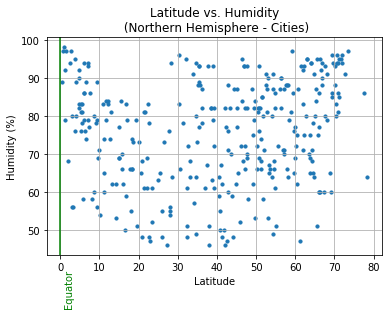

In [471]:
# Build a scatter plot or each data type
fig9 = plt.scatter(Northern_Hemisphere["Lat"], Northern_Hemisphere["Humidity"], marker="o", s=10)

plt.title("Latitude vs. Humidity\n (Northern Hemisphere - Cities)")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
# Adding an equator line, as a reference point
plt.axvline(0, color = 'green', alpha = 1, label = 'Equator')
plt.text(1,30,'Equator',rotation=90, color = 'green', alpha = 1)
plt.grid(True)

# Saving out the figure
plt.savefig("output_plots/Northern_Lat_vs_Max Temp.png")
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

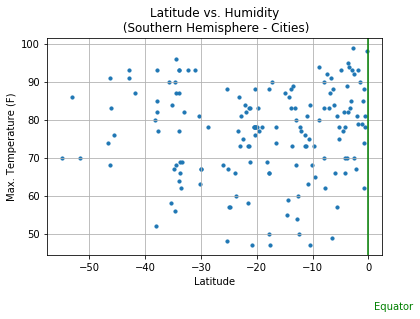

In [519]:
# Build a scatter plot or each data type
fig10 = plt.scatter(Southern_Hemisphere["Lat"], Southern_Hemisphere['Humidity'], marker="o", s=10)

plt.title("Latitude vs. Humidity\n (Southern Hemisphere - Cities)")
plt.xlabel("Latitude")
plt.ylabel("Max. Temperature (F)")
# Adding an equator line, as a reference point
plt.axvline(0, color = 'green', alpha = 1, label = 'Equator')
plt.text(1,30,'Equator',rotation=0, color = 'green', alpha = 1)
plt.grid(True)

# Saving out the figure
plt.savefig("output_plots/Southern_Lat_vs_Humidity.png")
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

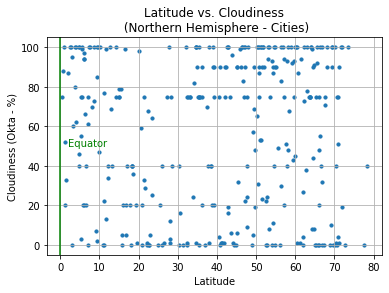

In [500]:
# Build a scatter plot for each data type
fig5 = plt.scatter(Northern_Hemisphere["Lat"], Northern_Hemisphere["Cloudiness"], marker="o", s=10)

# Adding Scatter 
plt.title("Latitude vs. Cloudiness\n (Northern Hemisphere - Cities)")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (Okta - %)")
# Adding an equator line, as a reference point
plt.axvline(0, color = 'green', alpha = 1, label = 'Equator')
plt.text(1.9,50,'Equator',rotation=0, color = 'green', alpha = 1)
plt.grid(True)

# Saving out the figure
plt.savefig("output_plots/Northern_Lat_vs_Cloudiness.png")

plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

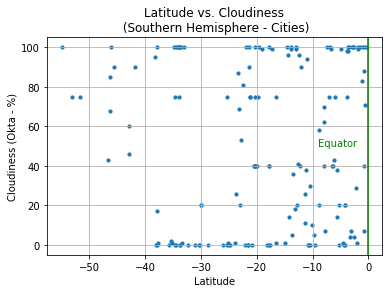

In [515]:
# Build a scatter plot for each data type
fig5 = plt.scatter(Southern_Hemisphere["Lat"], Southern_Hemisphere["Cloudiness"], marker="o", s=10)

# Adding Scatter 
plt.title("Latitude vs. Cloudiness\n (Southern Hemisphere - Cities)")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (Okta - %)")
# Adding an equator line, as a reference point
plt.axvline(0, color = 'green', alpha = 1, label = 'Equator')
plt.text(-9,50,'Equator',rotation=0, color = 'green', alpha = 1)
plt.grid(True)

# Saving out the figure
plt.savefig("output_plots/Southern_Lat_vs_Cloudiness.png")

plt.show()

## Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

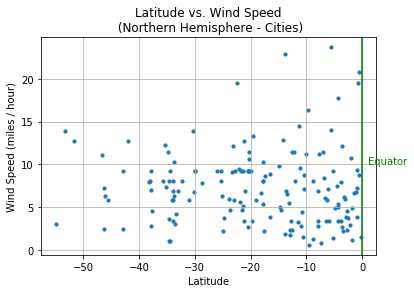

In [521]:
# Build a scatter plot for each data type
fig5 = plt.scatter(Southern_Hemisphere["Lat"], Southern_Hemisphere["Wind Speed"], marker="o", s=10)

# Adding Scatter 
plt.title("Latitude vs. Wind Speed\n (Northern Hemisphere - Cities)")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (miles / hour)")
# Adding an equator line, as a reference point
plt.axvline(0, color = 'green', alpha = 1, label = 'Equator')
plt.text(1,10,'Equator',rotation=0, color = 'green', alpha = 1)
plt.grid(True)

# Saving out the figure
plt.savefig("output_plots/Northern_Lat_vs_Wind_Speed.png")

plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression